In [1]:
import sys

sys.path.insert(1, '/Users/users/spirov/ThesisProject/Executable')

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import vaex
from cycler import cycler

from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union


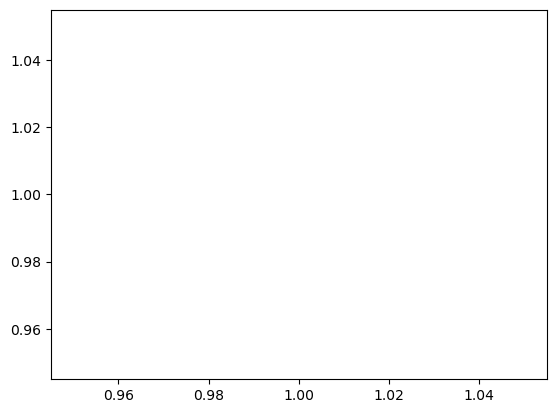

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

In [3]:


@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts, simps, rho):
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        #[v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        #Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return Drho

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        #self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

   

In [4]:
L = 128
sigma = 8
gamma = 1

def power(k, gamma):
    return k**gamma

def GRF(L, gamma, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    k2 = kx**2 + ky**2 + kz**2
    smooth_kernel = np.exp(- sigma ** 2 * k2 / 2)
    grf = np.fft.ifftn(
        np.sqrt(power(k2, gamma)) * 
                smooth_kernel * 
                np.fft.fftn(np.random.normal(0, 1, (L, L, L)))).real
    return grf / np.std(grf)

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    dataz = -np.fft.ifftn(kz * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay, dataz]),(1,2,3,0))

def Zeldovich(grf, D):
    velocities = gradient(grf)
    X, Y, Z = np.meshgrid(np.arange(L), np.arange(L), np.arange(L))
    points = np.transpose(np.array([X, Y, Z]), (1,2,3,0)) + D * velocities
    return (points.reshape(L**3, 3), velocities.reshape(L**3, 3))

grf = GRF(L, gamma, sigma)
points, velocities = Zeldovich(grf, 20)
m = np.ones(len(points))

In [5]:
from torch.nn.modules.loss import _Loss


import torch
from torch.utils.data import DataLoader
from torch import nn
from NeuralNets import CustomVaexDataset, printNodes, sc, StraightNetwork,Unet,Stefann

from torch.utils.data import Dataset
from DataCore import snapshotPath,L


In [6]:
p3 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"
test_set = CustomVaexDataset(p3)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)


In [7]:
lim = 1  #datapoint reduction factor
sc = 3e4   #scaling factor to allow model to behave itself

l = 11200

n = int(2**int(np.log2(l)))
torch.set_default_dtype(torch.float64)


In [8]:
class myDataset(Dataset):
    def __init__(self, frameDir):
        self.lengt = len(os.listdir(frameDir))
        self.frameDir = frameDir

    def __len__(self):
        return self.lengt

    def __getitem__(self, idx):
        fil = self.frameDir + os.listdir(self.frameDir)[idx]
        df = vaex.open(fil)

        th = df.Th.values[::lim]
        fi = df.Fi.values[::lim]
        R = df.R.values[::lim] / sc
        CZ = df.CZ.values[::lim] / sc


        broken = np.array((CZ, th, fi))
        truth = np.array(R)

        return torch.tensor(broken), torch.tensor(truth)

f = 2

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * l, int(n/(2*f))),
            nn.ReLU(),
            #nn.Dropout(0.35),
            nn.Linear(int(n/(2*f)),int(n/(4*f))),
            nn.Sigmoid(),
            nn.Linear(int(n/(4*f)),int(n/(8*f))),
            nn.ReLU(),
            nn.Linear(int(n/(8*f)),int(n/(2*f))),
            nn.Sigmoid(),
            #nn.Dropout(0.35),
            nn.Linear(int(n/(2*f)),int(n/f)),
            nn.ReLU(),
            nn.Linear(int(n/f),l)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
GoodPath = "/Users/users/spirov/ThesisProject/Snapshots/EYOOOOOOO.pt"

sd = torch.load(GoodPath,map_location=torch.device('cpu'))




In [10]:
for k in sd.keys():
    print(sd[k].shape)

#sd["linear_relu_stack.0.weight"].shape

torch.Size([2048, 335976])
torch.Size([2048])
torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([4096, 2048])
torch.Size([4096])
torch.Size([111992, 4096])
torch.Size([111992])


In [9]:

model =Unet() #BottleneckNetwork() # StraightNetwork() #


In [10]:


model.load_state_dict(sd)


<All keys matched successfully>

In [11]:
dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"

dataset = CustomVaexDataset(dataPath)

img, label = dataset.__getitem__(0)

with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))


Text(0, 0.5, 'residual')

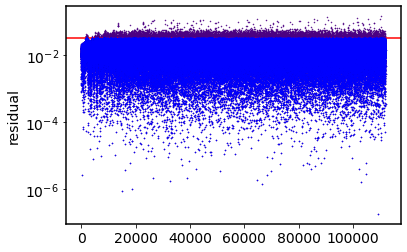

In [12]:
resid = (mod[0]-label).abs()

plt.plot(resid,marker='.',linestyle='',markersize=1)

plt.axhline(1e3/sc,c='r')

filt = resid<(1e3/sc)

plt.plot(np.arange(resid.size()[0])[filt],resid[filt],marker='.',linestyle='',markersize=1)

plt.yscale('log')
plt.ylabel("residual")


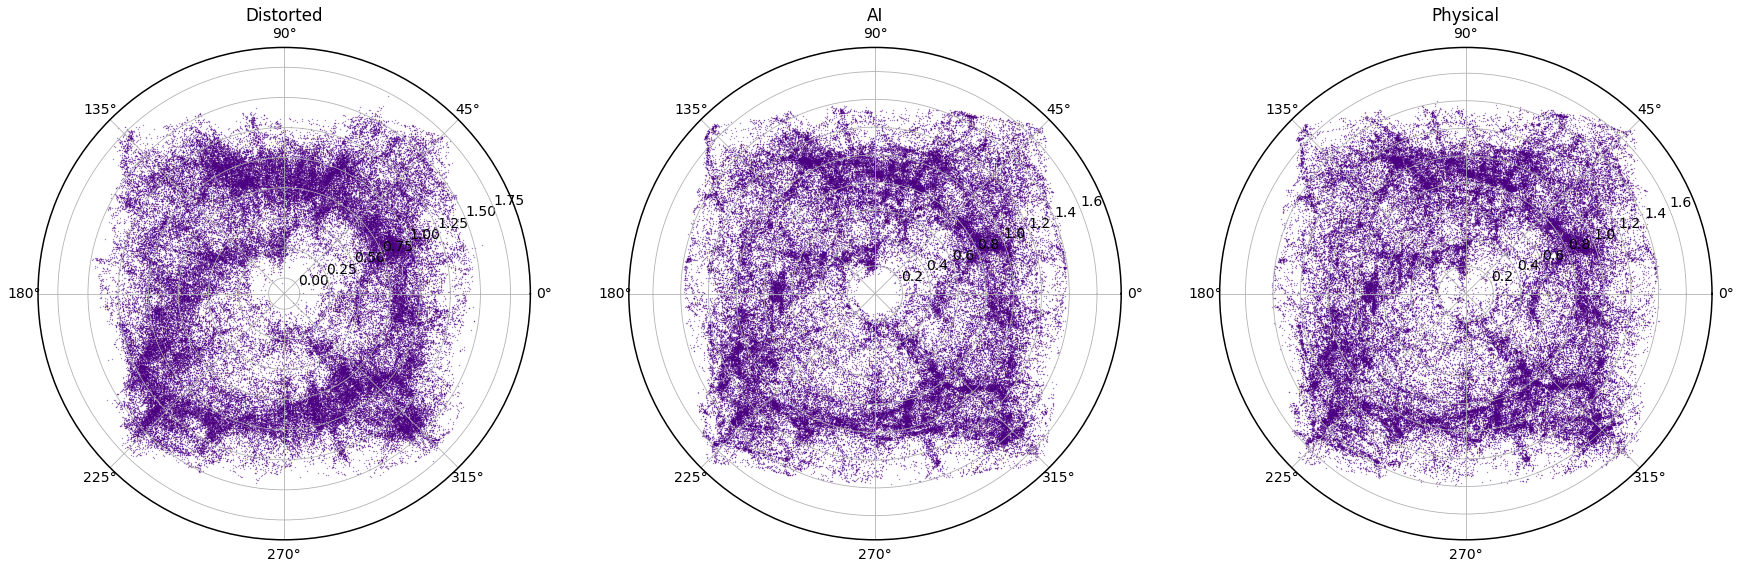

In [13]:
siz = 0.1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.scatter(img[2],img[0],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.scatter(img[2],mod,s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.scatter(img[2],label,s=siz,alpha=0.7)
plt.title("Physical")
plt.show()

In [14]:
dataFrame = vaex.from_arrays(R = label,Fi = img[2],Th = img[1], CZ = img[0], model = mod[0])

In [15]:
dataFrame

#        R                   Fi                   Th                   CZ                  model
0        0.6970897724975467  3.0841672228186328   0.3807840704591012   0.6735200575637551  0.7119808194312038
1        0.6757790382484218  -3.0235861870478407  0.42587821511608087  0.7876176928139711  0.6924857969123988
2        0.6828281871963858  3.0465721782492885   0.39063877059218305  0.8964213357791373  0.6947816559731084
3        0.6499088538087485  3.075873491862033    0.4367188264380599   0.8379663476455247  0.6544019397194711
4        0.7239670351648047  3.0620623249781946   0.3419232189590683   0.4378959639136772  0.7353693919841797
...      ...                 ...                  ...                  ...                 ...
111,987  1.0665043479731418  2.048355139822626    1.6096837230037067   1.0304127659808882  1.0423372848810912
111,988  1.1283216815201351  -2.446416893675759   0.9599477458188982   1.1679708245004494  1.1286576749638595
111,989  0.8608218817265553  2.407712655664305    0.9460785455292607   0.8254622122943934  0.8634730498969598
111,990  1.4754492219569182  -2.181712754983783   2.287173447023059    1.437201960468251   1.4613052591486204
111,991  0.9813525280737504  2.315225000339951    0.9228375214932222   0.9605315609635613  0.9861500673832365

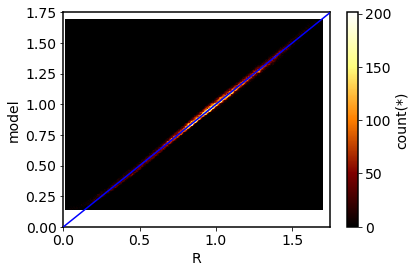

In [20]:
dataFrame.viz.heatmap("R","model")
place = [0,1.75]

plt.plot(place,place,c='blue',zorder=100)
plt.ylim(place)
plt.xlim(place)
plt.show()

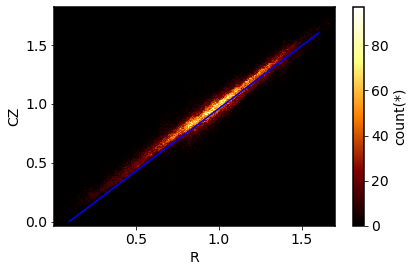

In [21]:
dataFrame.viz.heatmap("R","CZ")
plt.plot([0.1,1.6],[0,1.6],c='blue',zorder=100)
plt.show()

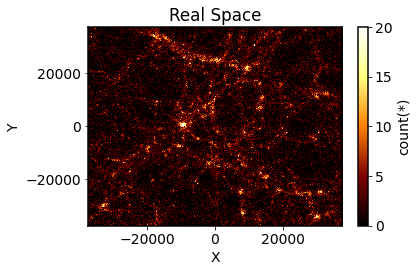

In [22]:
sc = 3.75e4

dataFrame.add_variable("sc",3.75e4)

dataFrame.add_virtual_column("X","R*sin(Th)*cos(Fi)*sc")
dataFrame.add_virtual_column("Y","R*sin(Th)*sin(Fi)*sc")
dataFrame.add_virtual_column("Z","R*cos(Th)*sc")

plt.title("Real Space")
dataFrame.viz.heatmap("X","Y",vmin=0,vmax=20,limits=(-3.75e4,3.75e4))
plt.show()

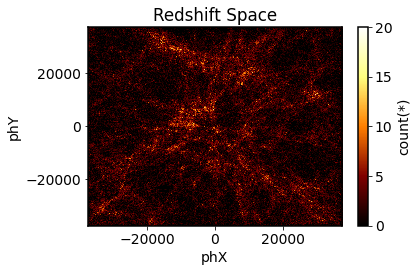

In [23]:
dataFrame.add_virtual_column("phX","CZ*sin(Th)*cos(Fi)*sc")
dataFrame.add_virtual_column("phY","CZ*sin(Th)*sin(Fi)*sc")
dataFrame.add_virtual_column("phZ","CZ*cos(Th)*sc")

plt.title("Redshift Space")
dataFrame.viz.heatmap("phX","phY",vmin=0,vmax=20,limits=(-3.75e4,3.75e4))
plt.show()

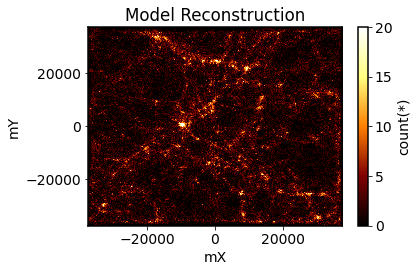

In [24]:
dataFrame.add_virtual_column("mX","model*sin(Th)*cos(Fi)*sc")
dataFrame.add_virtual_column("mY","model*sin(Th)*sin(Fi)*sc")
dataFrame.add_virtual_column("mZ","model*cos(Th)*sc")

plt.title("Model Reconstruction")
dataFrame.viz.heatmap("mX","mY",vmin=0,vmax=20,limits=(-3.75e4,3.75e4))
plt.show()

# DTFE Time

In [25]:
dataFrame.export_hdf5("./kernelSurvivor.hdf5")

In [5]:
dataFrame = vaex.open("./kernelSurvivor.hdf5")

In [6]:
width=3.8e4
zpoint = 0#-1.35e4

In [7]:
dataFrame.add_variable("zpoint",zpoint)
dataFrame.add_variable("width",width)
dataFrame.add_virtual_column("realFilter","((Z-width)<zpoint)*((Z+width)>zpoint)")
# dataFrame.add_virtual_column("phFilter","((phZ-width)<zpoint)*((phZ+width)>zpoint)")
# dataFrame.add_virtual_column("mFilter","((mZ-width)<zpoint)*((mZ+width)>zpoint)")


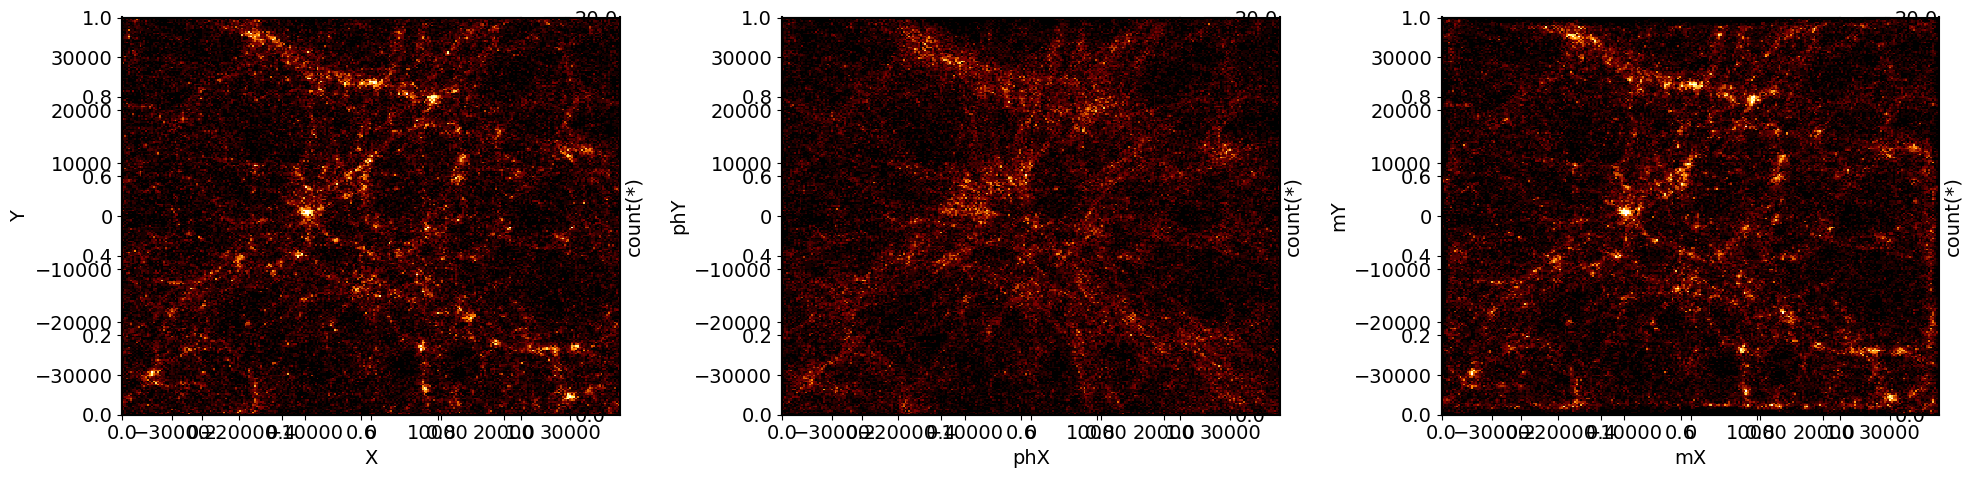

In [8]:
plt.figure(figsize=(20,5))
dataFrame.viz.heatmap([["X","Y"],["phX","phY"],["mX","mY"]],limits=(-3.75e4,3.75e4),vmin=0,vmax=20,)

# Real Space

In [42]:
df = dataFrame

p=np.array((df.X.values,df.Y.values,df.Z.values)).T
m=np.ones(len(df))

In [43]:
%%time
dtfe = DTFE(p, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 5.8 s, sys: 22.4 ms, total: 5.83 s
Wall time: 11.7 s


In [44]:
n=512
L = 75000

z = zpoint

X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(zpoint-width,zpoint+width,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())


In [45]:
den = d.reshape(n,n,n)
dens = den[den>0]

In [46]:
den/=np.median(den)

vmin = 1e2
l=24
vmax=1e4

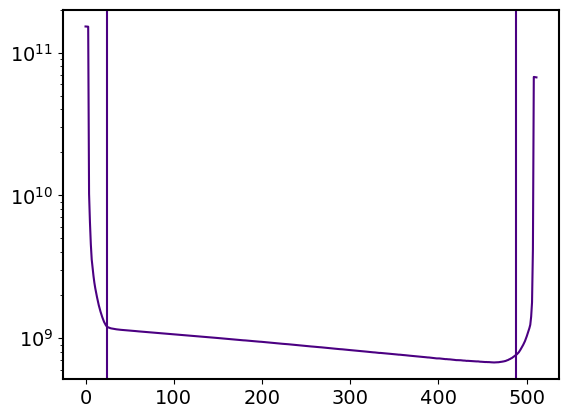

In [47]:
plt.plot(den.sum((0,1)))
plt.yscale('log')
plt.axvline(l)
plt.axvline(n-l)
plt.show()

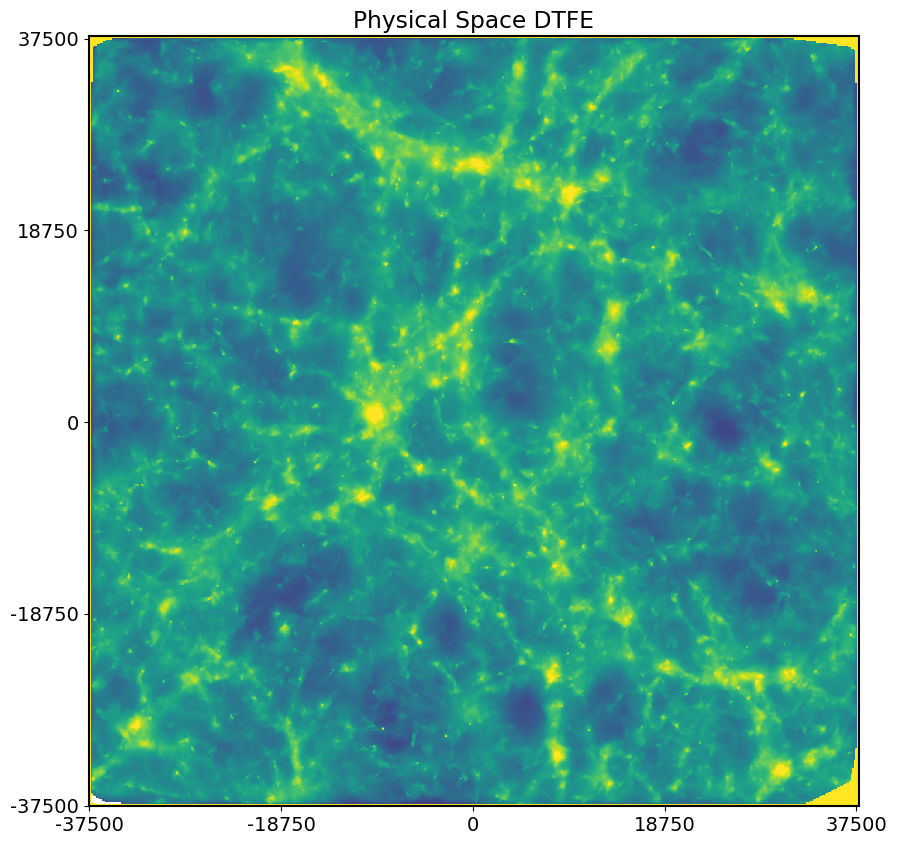

In [48]:
fig = plt.figure(figsize=(10,10))
plt.imshow(den[:,:,l:-l].sum(2),norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))


plt.title("Physical Space DTFE")
#plt.xlabel("X Direction [kpc/h]")
#plt.ylabel("Y Direction [kpc/h]")
#cb = plt.colorbar()
#cb.set_label("Scaled Density")
plt.show()

In [93]:
np.save("../Data/Densities/PhysicalSpace.npy",den)

In [94]:
physSlice = den[int(n/2-n/8):int(n/2+n/8),int(n/4):int(n/2),l:-l].sum(2)

In [95]:
del den
del dens
del dtfe

# Phase DTFE

In [35]:
#df = dataFrame#[dataFrame.phFilter]

p=np.array((df.phX.values,df.phY.values,df.phZ.values)).T
m=np.ones(len(df))


In [36]:
%%time
dtfe = DTFE(p, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 5.23 s, sys: 17.6 ms, total: 5.25 s
Wall time: 10.5 s


In [37]:
d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())
den = d.reshape(n,n,n)
dens = den[den>0]

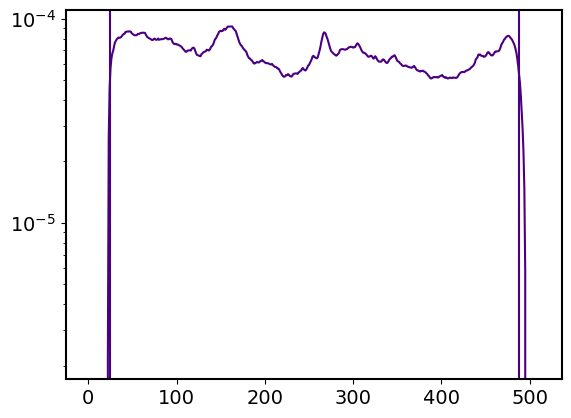

In [38]:
plt.plot(den.sum((0,1)))
plt.yscale('log')
plt.axvline(l)
plt.axvline(n-l)
plt.show()

In [39]:
den/=np.median(den)

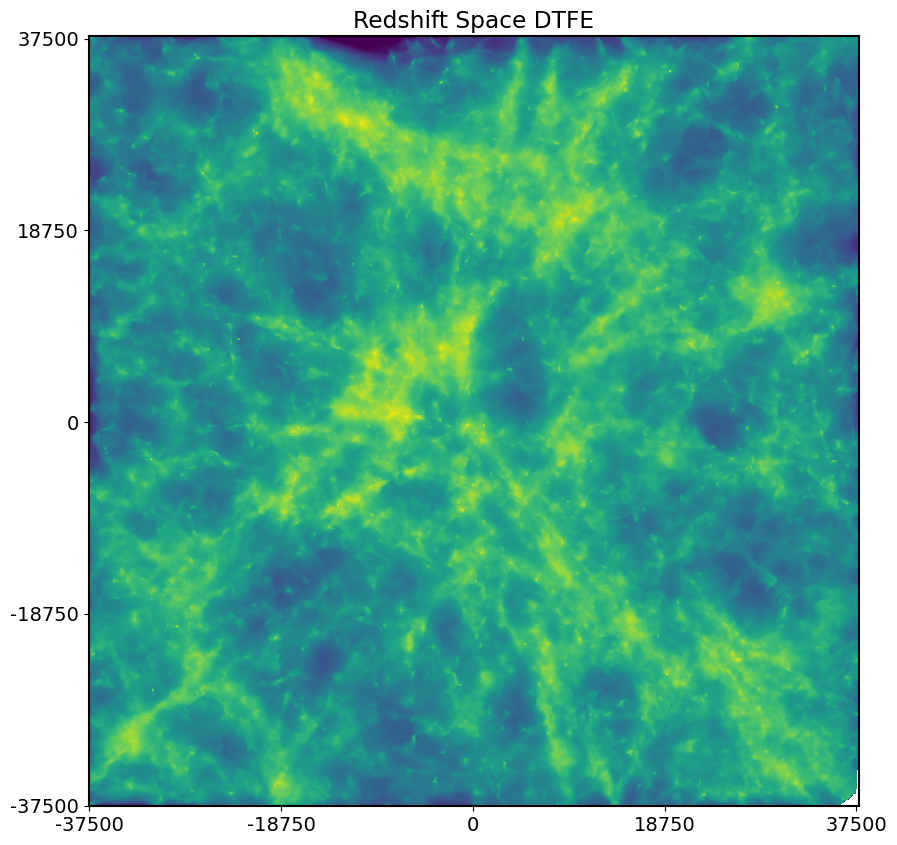

In [41]:
fig = plt.figure(figsize=(10,10))

plt.imshow(den[:,:,l:-l].sum(2),norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))


plt.title("Redshift Space DTFE")
#plt.xlabel("X Direction [kpc/h]")
#plt.ylabel("Y Direction [kpc/h]")
#cb = plt.colorbar()
#cb.set_label("Scaled Density")
plt.show()

In [102]:
np.save("../Data/Densities/RedshiftSpace.npy",den)

In [103]:
redSlice = den[int(n/2-n/8):int(n/2+n/8),int(n/4):int(n/2),l:-l].sum(2)

In [104]:
del den
del dens
del dtfe

# Model Space

In [105]:
p=np.array((df.mX.values,df.mY.values,df.mZ.values)).T
m=np.ones(len(df))

dtfe = DTFE(p, m)

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())
den = d.reshape(n,n,n)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients


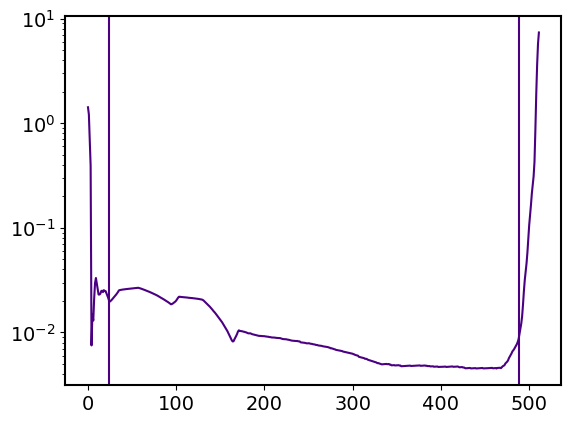

In [106]:
plt.plot(den.sum((0,1)))
plt.yscale('log')
plt.axvline(l)
plt.axvline(n-l)
plt.show()

In [107]:
den/=np.median(den)

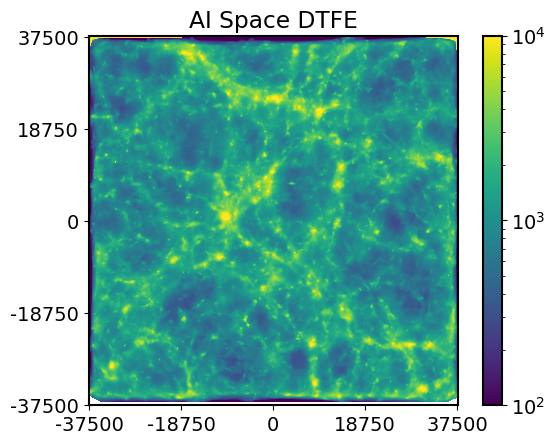

In [108]:

plt.imshow(den[:,:,l:-l].sum(2),norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))

plt.xlabel("X Direction [kpc/h]")
plt.ylabel("Y Direction [kpc/h]")

plt.title("AI Space DTFE")
plt.colorbar()
plt.show()

In [109]:
np.save("../Data/Densities/ModelSpace.npy",den)

In [110]:
modSlice = den[int(n/2-n/8):int(n/2+n/8),int(n/4):int(n/2),l:-l].sum(2)

# Looking for a cluster

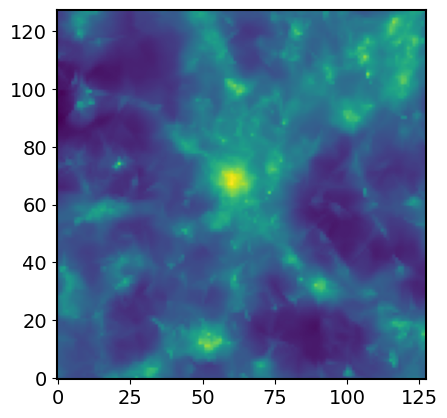

In [39]:
plt.imshow(den[int(n/2-n/8):int(n/2+n/8),int(n/4):int(n/2),l:-l].sum(2),norm='log',origin='lower')
plt.show()

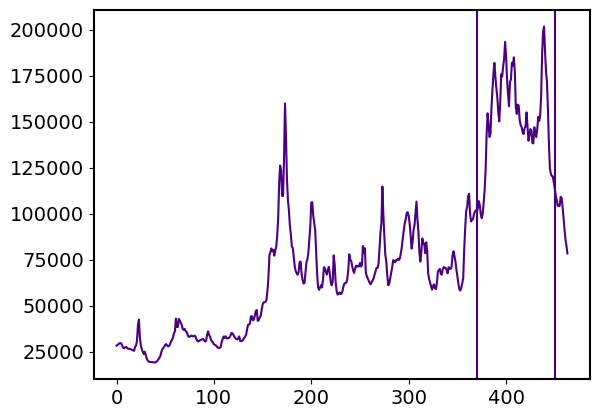

In [40]:
plt.plot(den[int(n/2-n/8):int(n/2+n/8),int(n/4):int(n/2),l:-l].sum((0,1)))
m1 = 370
m2 = 450
plt.axvline(m1)
plt.axvline(m2)

In [43]:
del dtfe
del den

NameError: name 'den' is not defined

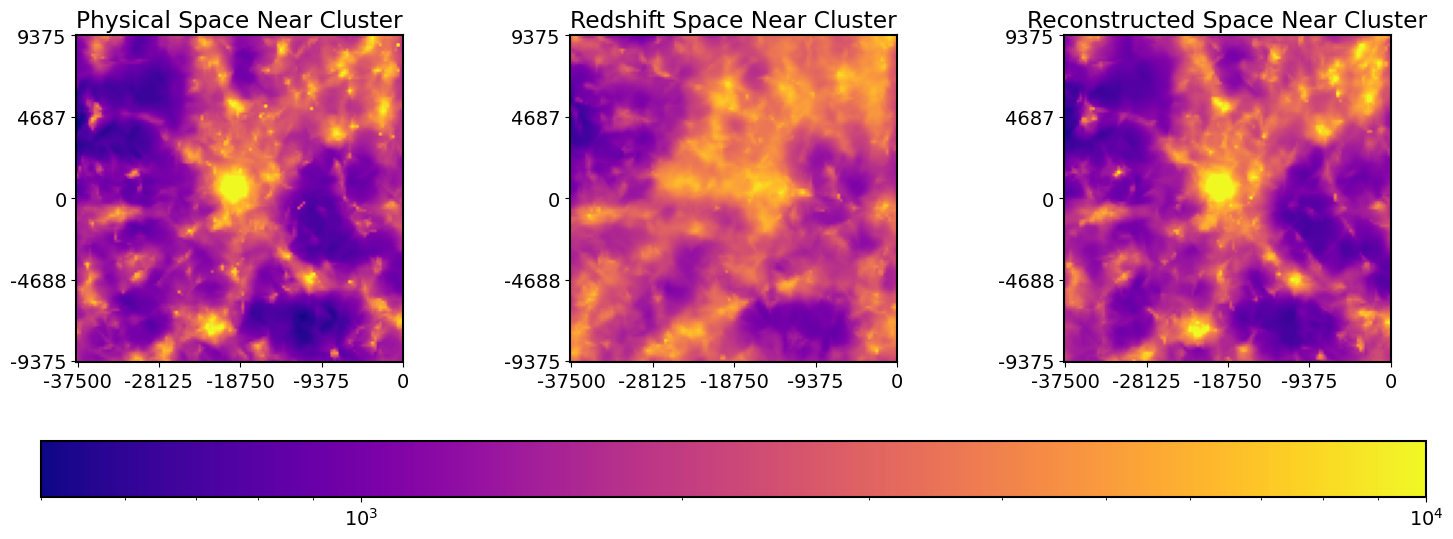

In [153]:
fig, axes = plt.subplot_mosaic(
"""
.AAAAA.BBBBB.CCCCC.
.AAAAA.BBBBB.CCCCC.
.AAAAA.BBBBB.CCCCC.
.AAAAA.BBBBB.CCCCC.
.AAAAA.BBBBB.CCCCC.
...................
.DDDDDDDDDDDDDDDDD.
"""
,figsize=(20,6))


vmax = 1e4
vmin = 5e2

ax1 =axes["A"]
im = ax1.imshow(physSlice,norm="log",origin="lower",vmin=vmin,vmax=vmax,cmap='plasma')
ax1.set_xticks(np.linspace(0,n/4,5), np.linspace(x1,x2,5,dtype=int))
ax1.set_yticks(np.linspace(0,n/4,5), np.linspace(y1,y2,5,dtype=int))
ax1.set_title("Physical Space Near Cluster")


ax2 =axes["B"]
ax2.imshow(redSlice,norm="log",origin="lower",vmin=vmin,vmax=vmax,cmap='plasma')
ax2.set_xticks(np.linspace(0,n/4,5), np.linspace(x1,x2,5,dtype=int))
ax2.set_yticks(np.linspace(0,n/4,5), np.linspace(y1,y2,5,dtype=int))
ax2.set_title("Redshift Space Near Cluster")


ax3 = axes["C"]
cd=ax3.imshow(modSlice,norm="log",origin="lower",vmin=vmin,vmax=vmax,cmap='plasma')
ax3.set_xticks(np.linspace(0,n/4,5), np.linspace(x1,x2,5,dtype=int))
ax3.set_yticks(np.linspace(0,n/4,5), np.linspace(y1,y2,5,dtype=int))
ax3.set_title("Reconstructed Space Near Cluster")


#divider = make_axes_locatable(axes)
colbarframe = axes["D"]#fig.add_axes([0,1,2,2]) #xes.append_axes("bottom", size="5%", pad=0.7)
cbar = fig.colorbar(im, cax=colbarframe, orientation="horizontal")
#cbar.set_label("Ratio P2/(P1+P2)")

#plt.suptitle("Reconstruction of a cluster")
plt.show()



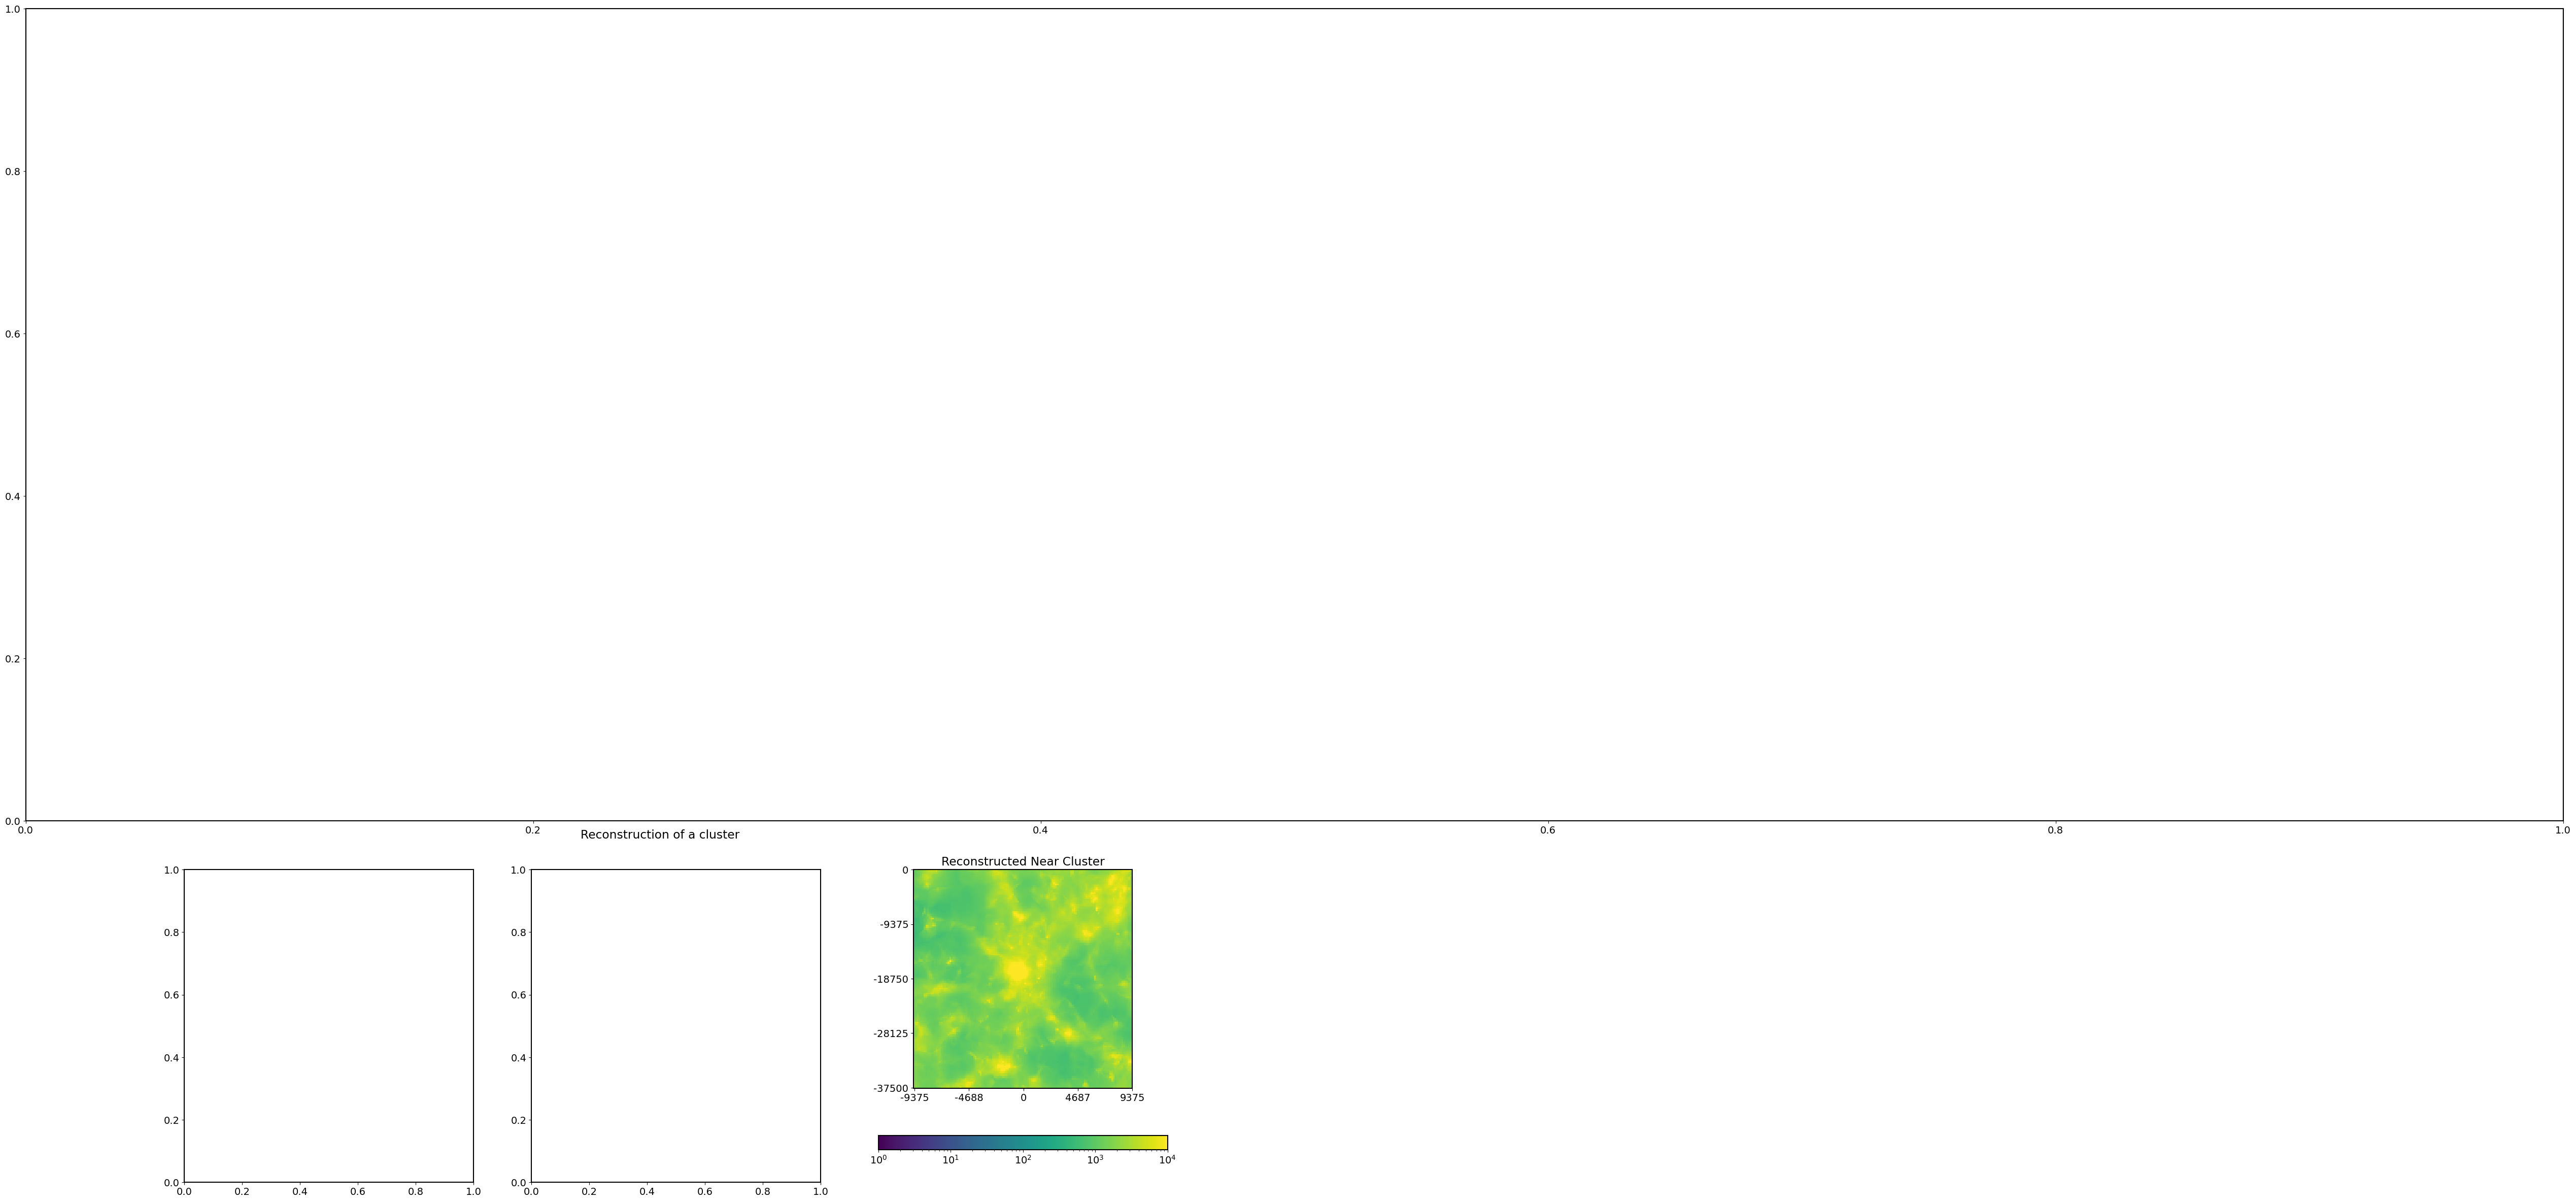

In [130]:
fig, axes = plt.subplots(ncols=3,figsize=(25,8))


vmax = 1e4
vmin = 1e0

ax1 =axes[0]
im = plt.imshow(physSlice,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n/4,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n/4,5), np.linspace(y1,y2,5,dtype=int))
plt.title("Physical Near Cluster")


ax2 =axes[1]
plt.imshow(redSlice,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n/4,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n/4,5), np.linspace(y1,y2,5,dtype=int))
plt.title("Redshift Near Cluster")


ax3 = axes[2]
cd=plt.imshow(modSlice,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n/4,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n/4,5), np.linspace(y1,y2,5,dtype=int))
plt.title("Reconstructed Near Cluster")


#divider = make_axes_locatable(axes)
colbarframe = fig.add_axes([0,1,2,2]) #xes.append_axes("bottom", size="5%", pad=0.7)
cbar = fig.colorbar(im, orientation="horizontal")
#cbar.set_label("Ratio P2/(P1+P2)")

plt.suptitle("Reconstruction of a cluster")
plt.show()



# Specifically a Dense Region

In [79]:
vmax=1e-6
vmin=1e-8
n=256
m1 /=2
m2 /= 2
l=1

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients


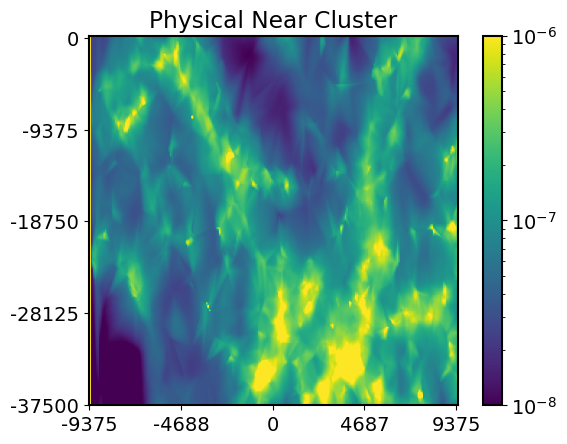

In [82]:
df = dataFrame#[dataFrame.realFilter]

p=np.array((df.X.values,df.Y.values,df.Z.values)).T
m=np.ones(len(df))

dtfe = DTFE(p, m)

x1 = -L/4
x2 = 0

y1 = -L/8
y2 = L/8

z1 = L/2*m1/n
z2 = L/2*m2/n

X,Y,Z = np.meshgrid(np.linspace(x1,x2,n),np.linspace(y1,y2,n),np.linspace(z1,z2,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())

den = d.reshape(n,n,n)

physDen = den[:,:,l:-l].sum(2)

plt.imshow(physDen,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n,5), np.linspace(y1,y2,5,dtype=int))


plt.title("Physical Near Cluster")
plt.colorbar()
plt.show()

In [68]:
df = dataFrame#[dataFrame.phFilter]

p=np.array((df.phX.values,df.phY.values,df.phZ.values)).T
m=np.ones(len(df))

dtfe = DTFE(p, m)


X,Y,Z = np.meshgrid(np.linspace(x1,x2,n),np.linspace(y1,y2,n),np.linspace(z1,z2,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())

den = d.reshape(n,n,n)
dens = den[den>0]

redDen = den[:,:,l:-l].sum(2)

plt.imshow(redDen,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(y1,y2,5,dtype=int))


plt.title("Redshift Near Cluster")
plt.colorbar()
plt.show()

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients


KeyboardInterrupt: 

In [ ]:
df = dataFrame#[dataFrame.mFilter]

p=np.array((df.mX.values,df.mY.values,df.mZ.values)).T
m=np.ones(len(df))

dtfe = DTFE(p, m)

gamer = 0



X,Y,Z = np.meshgrid(np.linspace(x1,x2,n),np.linspace(y1,y2,n),np.linspace(z1,z2,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())

den = d.reshape(n,n,n)
dens = den[den>0]

modelDen = den[:,:,l:-l].sum(2)

plt.imshow(modelDen,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(y1,y2,5,dtype=int))


plt.title("Reconstructed Near Cluster")
plt.colorbar()
plt.show()

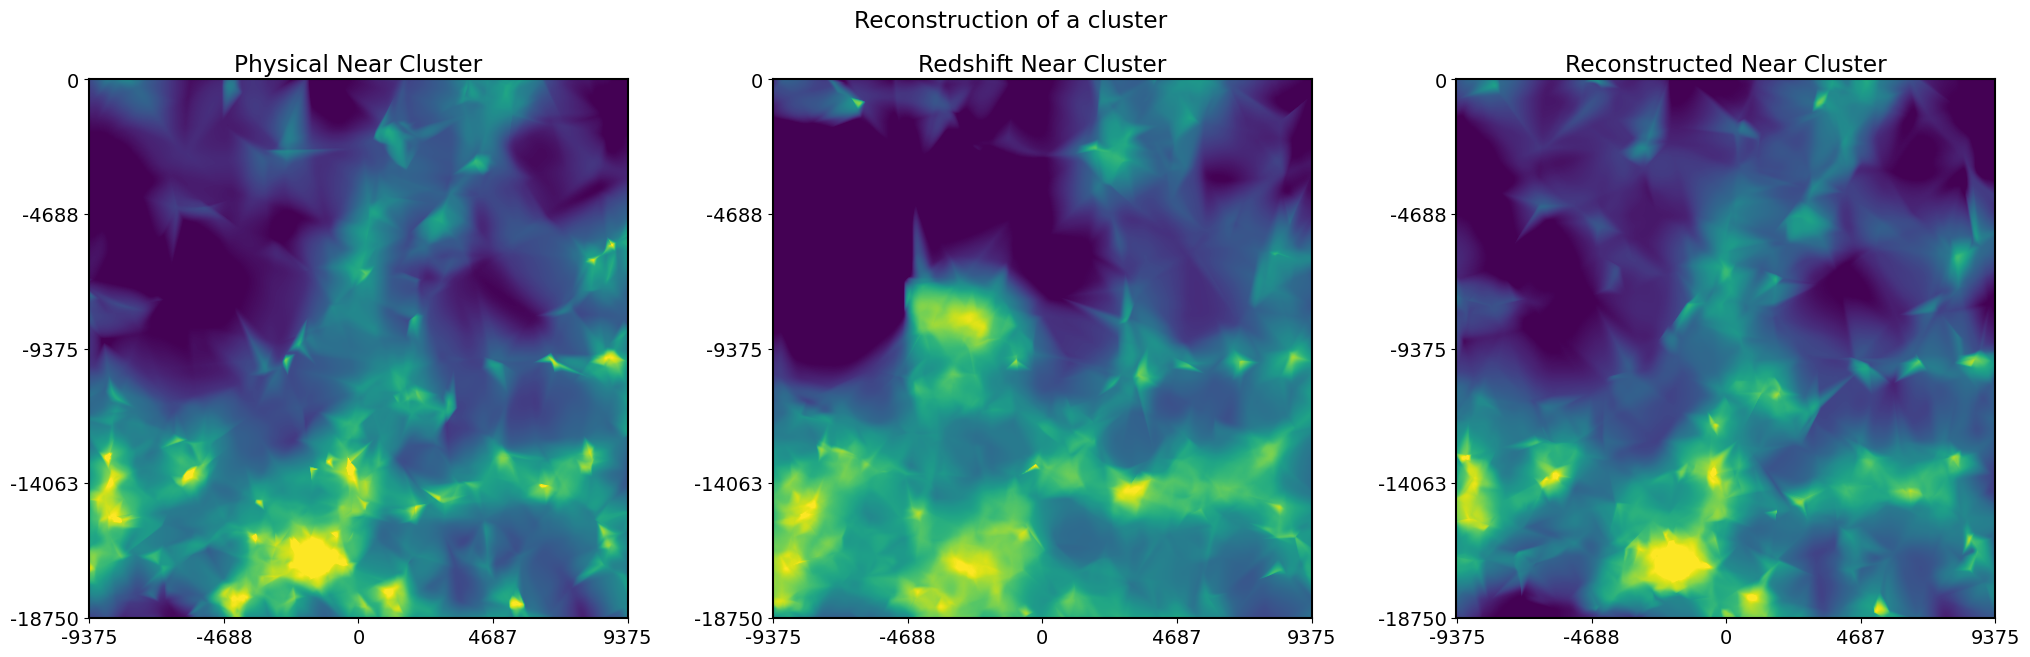

In [64]:
fig = plt.figure(figsize=(25,7))


vmax = 5e-6
vmin = 5e-8

plt.subplot(131)
plt.imshow(physDen,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n,5), np.linspace(y1,y2,5,dtype=int))
plt.title("Physical Near Cluster")


plt.subplot(132)
plt.imshow(redDen,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n,5), np.linspace(y1,y2,5,dtype=int))
plt.title("Redshift Near Cluster")


plt.subplot(133)
cd=plt.imshow(modelDen,norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n,5), np.linspace(x1,x2,5,dtype=int))
plt.xticks(np.linspace(0,n,5), np.linspace(y1,y2,5,dtype=int))
plt.title("Reconstructed Near Cluster")



#fig.colorbar(cd)

plt.suptitle("Reconstruction of a cluster")
plt.show()

